In [1]:
import joblib
import pandas as pd
import os
import numpy as np
import pickle
import sklearn
import gensim
from sklearn.feature_extraction.text import CountVectorizer


# Utility Functions Here!

In [2]:
# a utility function to display the topics and for each topic we choose the top most frequent words
def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic {topic_id}')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

def show_doc_topic_matrix(model, vecs, num_doc_to_show = 10, to_styler=True):
    # model = a trained sklearn lda model
    # vecs = output from the CountVectorizer transform
    lda_output = model.transform(vecs)
    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 6), 
                                     columns=[f'topic{i}' for i in range(model.n_components)], 
                                     index=[f'doc{i}' for i in range(vecs.shape[0])])

    # Get dominant topic for each document
    df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)



    # apply style and return the dataframe
    df_out = df_document_topic.head(num_doc_to_show)
    if to_styler:
        return df_out.style.applymap(color_green).applymap(make_bold)
    else:
        return df_out

# function to show exponential value of expectation of log topic word distribution = exp(E[log(beta)])

def show_topic_token_matrix(model, feature_names, num_top_words = 10):
    # model = a trained sklearn lda model
    # feature_names = fitted CountVectorizer.get_feature_names_out()
    top_tokens_per_topic = []

    for topic_id, topic in enumerate(model.components_):
        topic_token_p = [(topic_id, feature_names[i], topic[i]) for i in topic.argsort()[:-num_top_words - 1:-1]]
        top_tokens_per_topic.extend(topic_token_p)

    return pd.DataFrame(top_tokens_per_topic, columns=['topic', 'token', 'e_exp_log_beta'])
    
# Styling
def color_green(val):
    if 0 < val < 1:
        color = 'black' if val > .1 else 'grey'
        return f'color: {color}'

def make_bold(val):
    if 0 < val < 1:
        weight = 'bold' if val > .1 else 'lighter'
        return f'font-weight: {weight}'
    


# Initialize Vectorizer

In [3]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # min occurrences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )


X_train = pd.read_pickle("X_Train_nonSuicidal.pkl")
df_filtered_lemmatized = X_train["text_lemmatized"].tolist()

stop_list = ("suicidal", "suicide", "aah", "fuck")
df_filtered_lemmatized_removeSuicide = [[w for w in doc if w not in stop_list] for doc in df_filtered_lemmatized]
df_filtered_lemmatized_joined = [' '.join(x) for x in df_filtered_lemmatized_removeSuicide]  # joined to fit CountVectorizer
train1_vecs = vectorizer.fit_transform(df_filtered_lemmatized_joined)
feature_names = vectorizer.get_feature_names_out()

In [4]:
print(feature_names[:20])

['aba' 'abandon' 'abandonment' 'abide' 'ability' 'able' 'abnormal'
 'abolish' 'abort' 'abortion' 'abroad' 'abs' 'absence' 'absent' 'absolute'
 'absolutely' 'absorb' 'absurd' 'abuse' 'abused']


# Load Model

In [5]:
#print('The joblib version is {}.'.format(joblib.__version__))
lda_suicidal_model = joblib.load('non_suicidal_lda_model.jl')
lda_output = lda_suicidal_model.get_feature_names_out()
print(lda_output)

['latentdirichletallocation0' 'latentdirichletallocation1'
 'latentdirichletallocation2' 'latentdirichletallocation3'
 'latentdirichletallocation4' 'latentdirichletallocation5'
 'latentdirichletallocation6' 'latentdirichletallocation7'
 'latentdirichletallocation8' 'latentdirichletallocation9']


In [6]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_suicidal_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names_out()
topicnames = ["Topic" + str(i) for i in range(lda_suicidal_model.n_components)]
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,aba,abandon,abandonment,abide,ability,able,abnormal,abolish,abort,abortion,...,zelda,zen,zero,zing,zip,zodiac,zombie,zone,zoo,zoom
Topic0,0.100004,0.100002,0.100000,0.100000,0.100022,0.100032,0.100005,0.100007,0.100006,0.100003,...,0.100027,0.100000,0.100002,0.100000,0.100001,0.100000,0.100001,0.100051,0.100002,0.100002
Topic1,0.100048,0.100030,0.100007,0.100014,19.374638,0.100024,0.100017,0.100041,0.100036,0.100010,...,0.100010,11.985474,0.100026,0.100028,0.100046,0.100012,103.036314,0.100049,0.100024,0.100016
Topic2,0.100123,0.100024,0.100005,0.100042,34.653206,83.963869,0.100008,0.100008,0.100075,41.932854,...,21.931448,0.100014,0.100029,0.100023,0.100017,0.100016,0.100022,0.100030,0.100022,0.100018
Topic3,0.100054,0.100033,0.100003,0.100008,0.100028,0.100024,0.100023,0.100012,0.100066,0.100011,...,0.100010,0.100016,0.100021,0.100027,0.100038,0.100025,0.100015,0.100017,0.100030,0.100010
Topic4,16.551777,0.100020,0.100018,0.100016,0.100028,0.100029,13.014089,0.100021,0.100063,0.100015,...,0.100004,0.100010,1.668490,0.100018,0.100028,0.100014,0.100012,0.100028,0.100024,0.100011


In [7]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_suicidal_model.score(train1_vecs))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_suicidal_model.perplexity(train1_vecs))
# See model parameters
print(lda_suicidal_model.get_params())

Log Likelihood:  -9012171.147061339
Perplexity:  1336.617991085162
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': None, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


# Predicting Topic


In [11]:
#!spacy download en_core_web_sm

# Define function to predict topic for a given text document.
#!pip install -U spacy
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(model, vectorizer, text):
    global sent_to_words
    global lemmatization
    
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 0:20].values.tolist()
    
    # Step 5: Infer Topic
    infer_topicNo = np.argmax(topic_probability_scores)
    infer_topic = df_topic_keywords.iloc[infer_topicNo, 0]
    themes = ["Election", "Sex", "Gaming", "Food", "Happiness", "School", "Videos", "Parents", "Relationship", "Friendship"]
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return themes[infer_topicNo], topic, infer_topicNo, topic_probability_scores


In [12]:
show_doc_topic_matrix(lda_suicidal_model, train1_vecs)

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_suicidal_model)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,filler,opt,ftp,uncomfortable,election,pant,asks,confused,suit,requirement,swag,harry,discus,chick,bridge
Topic 1,cum,number,star,earth,man,light,voice,world,space,country,card,stream,band,blue,piss
Topic 2,play,game,post,people,like,song,want,sub,pop,edit,sure,teenager,new,look,meme
Topic 3,eat,award,brush,brother,bacon,eve,car,add,water,chocolate,food,run,amp,christmas,favourite
Topic 4,day,today,post,sex,text,good,birthday,die,happy,opinion,wake,people,type,half,night
Topic 5,god,room,stupid,test,hand,hey,use,shit,plus,listen,study,come,walk,book,drive
Topic 6,help,geddit,watch,need,discord,learn,guy,tip,account,post,video,scar,movie,server,youtube
Topic 7,mon,year,gon,old,tell,question,dad,ask,know,shes,time,comment,care,live,ago
Topic 8,like,girl,love,guy,shit,wan,want,bore,sleep,look,know,people,hate,think,boy
Topic 9,like,friend,want,know,talk,school,feel,time,think,live,thing,say,people,start,tell


# Prediction

In [13]:
mytext = [""" "Everyone wants to be "edgy and it's making me self conscious I feel like I don't stand out. I can draw yes and play the guitar but I honestly feel like am stuck in the past, my taste in music are all rock and alt metal from
2000's to the 90's and it doesn't really make me feel unique it's just my style but seeing as my friends and classmates getting more into rap and EDM it's hard for me to feel like I fit in.
The I don't feel like I stand out is because of all the others copying a style and if I do that I'd be just another
""Quirky kid"" who's in a cringey phase.
Many of my friends say that I look good in grunge style and I kinda agree but it's hard for me to continue that if I can't even stand out from all the ""edgy
People who wore crosses and wallet chains and do tiktoks""

Really feels like I don't fit in in all categories, am scared that people might confuse me with a CLOUT CHASER or a fucking tiktok e boy goddamn
I hate my life"

         """]

infer_topic, topic, infer_topicNo, prob_scores = predict_topic(lda_suicidal_model, vectorizer = vectorizer, text = mytext)

print("Topic: " + str(infer_topicNo) + " - " +  infer_topic)
print(topic)

Topic: 9 - Friendship
['like', 'friend', 'want', 'know', 'talk', 'school', 'feel', 'time', 'think', 'live', 'thing', 'say', 'people', 'start', 'tell']


# Trying to cluster

In [14]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_suicidal_model.components_)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_suicidal_model.components_)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Component's weights: 
 [[ 0.    0.    0.   ...  0.    0.    0.01]
 [ 0.    0.    0.   ...  0.    0.   -0.  ]]
Perc of Variance Explained: 
 [0.46 0.27]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

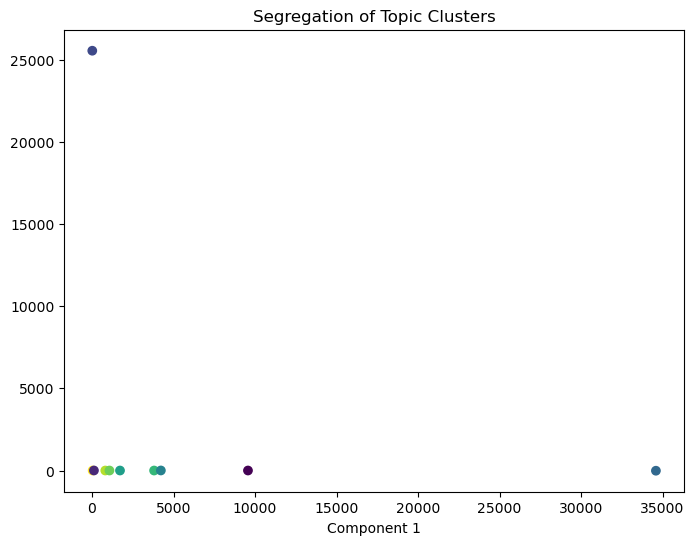

In [15]:
import matplotlib.pyplot as plot

plot.figure(figsize=(8,6))
plot.scatter(x, y, c=clusters)
plot.xlabel('Component 2')
plot.xlabel('Component 1')
plot.title("Segregation of Topic Clusters", )

In [16]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_column):
  topics = model.components_

  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_column]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

In [17]:
coherence = get_Cv(df_column=df_filtered_lemmatized_joined, model=lda_suicidal_model)

In [18]:
print(coherence)

0.6798780756265634
